In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import sys

In [2]:
fpar_path =  "../data/training/iapar/cper_ndvi_plotscale_2014_2022_fnl.csv" 
par_path = "../data/sensors/par/neon_d10_cper_par_cln.csv"
ground_path = "../data/ground/clipping/AGM_Biomass_Widecln_attr_2023-07-13.csv"
dates_path = "../data/ground/clipping/CARM_Biomass_SamplingDates.csv"

In [3]:
def ndvi_to_fpar(ndvi_ts):
    SR = (1 + ndvi_ts) / (1 - ndvi_ts)
    # SR_min = 1.55  # this is based on Grigera et al., 2007
    SR_min = 1.11  # this is based on an NDVI of 0.05
    SR_max = 11.62
    fPAR = SR / (SR_max - SR_min) - SR_min / (SR_max - SR_min)
    return fPAR

In [10]:
fpar = pd.read_csv(fpar_path)
par = pd.read_csv(par_path)
ground = pd.read_csv(ground_path)
s_dates = pd.read_csv(dates_path)

In [11]:
fpar['Year'] = pd.DatetimeIndex(fpar['Date']).year
par['Year'] = pd.DatetimeIndex(par['Date']).year
s_dates['Year'] = pd.DatetimeIndex(s_dates['SamplingDate']).year

fpar['fPAR'] = ndvi_to_fpar(fpar['NDVI_smooth_avg'])

# rename pasture in ground data
ground.loc[ground['Pasture'] == 'NH', 'Pasture'] = '10S'
s_dates.loc[s_dates['Pasture'] == 'NH', 'Pasture'] = '10S'

#create new column in ground that is a combination of Pasture and plot the format "Pasture_"P"Plot"
ground['Id'] = ground['Pasture'].astype(str) + '_' + "P"+ ground['Plot'].astype(str)
#add same column to sampling_dates
s_dates['Id'] = s_dates['Pasture'].astype(str) + '_' + "P"+ s_dates['Plot'].astype(str)
#add year column to sampling_dates

s_dates['Year'] = pd.DatetimeIndex(s_dates['SamplingDate']).year
#drop Pasture, Plot, Transect, Distance columns from sampling_dates
s_dates = s_dates.drop(columns=['Transect', 'Distance', 'Plot', 'Pasture'])

In [12]:
#BIOMASS CALCULATIONS

#group by transect, sum biomass
#group by plot and get mean
"""
ground_filtered = ground[~ground['FGCode'].isin(['SS', 'SD'])]
ground_total_biomass = ground_filtered.groupby(['YearSampled', 'Id', 'Transect'])['kgPerHa'].sum().reset_index()
ground_total_biomass = ground_total_biomass.groupby(['YearSampled', 'Id'])['kgPerHa'].mean().reset_index()

ground_total_biomass = ground_total_biomass.rename(columns={"kgPerHa": "Total_Biomass"})

ground = pd.merge(ground, ground_total_biomass, on=['YearSampled', 'Id'])
#rename YearSampled to Year
"""

# List of biomass columns to be summed
biomass_cols = ['BOBU', 'WSPG', 'C3PG', 'FORB', 'AG']#, 'C4PG', 'VUOC']

# Calculate the sum of the biomass columns for each year and id
ground['Total_Biomass'] = ground[biomass_cols].sum(axis=1)
#rename 'YearSampled' to Year
ground = ground.rename(columns={"YearSampled": "Year"})

# Group by 'Year' and 'ID', and calculate the mean of 'Total_Biomass'
ground_total_biomass = ground.groupby(['Year', 'Id'])['Total_Biomass'].mean().reset_index()

# Merge ground_total_biomass back into the original DataFrame
ground = pd.merge(ground, ground_total_biomass, on=['Year', 'Id'], suffixes=('', '_mean'))


#drop total biomass column
ground = ground.drop(columns=['Total_Biomass'])
#rename TOtal Biomass_mean to Total_Biomass
ground = ground.rename(columns={"Total_Biomass_mean": "Total_Biomass"})

#Take the Total_Biomass column, Year, and Id columns from ground into temp dataframe
temp = ground[['Total_Biomass', 'Year', 'Id','Treatment', 'Pasture', 'Plot']]
print(temp)

      Total_Biomass  Year      Id Treatment Pasture  Plot
0        639.196667  2013  15E_P1       TGM     15E     1
1        639.196667  2013  15E_P1       TGM     15E     1
2        639.196667  2013  15E_P1       TGM     15E     1
3        701.940000  2013  15E_P2       TGM     15E     2
4        701.940000  2013  15E_P2       TGM     15E     2
...             ...   ...     ...       ...     ...   ...
3496     955.905000  2021  10S_P3       AGM     10S     3
3497    1250.917500  2021  10S_P4       AGM     10S     4
3498    1250.917500  2021  10S_P4       AGM     10S     4
3499    1250.917500  2021  10S_P4       AGM     10S     4
3500    1250.917500  2021  10S_P4       AGM     10S     4

[3501 rows x 6 columns]


In [14]:
#rename StartDateTime column from par to Date and PAR_MJ_m2_day to PAR
par = par.rename(columns={"startDateTime": "Date", "PAR_MJ_m2_day": "PAR"})

APAR = fpar[['Date', 'Id', 'fPAR','NDVI_smooth_avg','Year']]
#convert Date column to datetime

#merge ground with APAR on Year and Id
APAR = pd.merge(APAR, temp, on=['Year', 'Id'])

APAR['Date'] = APAR['Date'].str.replace(r'\s.*', '', regex=True)
# #merge on Date

#take only date and PAR columns from PAR
par = par[['Date', 'PAR']]
APAR = pd.merge(APAR, par, on='Date')

#sort by Id, Date
APAR = APAR.sort_values(by=['Id', 'Date'])
#add APAR column, which is fPAR * PAR
APAR['APAR'] = APAR['fPAR'] * APAR['PAR']
#Add year column
APAR['Year'] = pd.DatetimeIndex(APAR['Date']).year


#drop Row	Pasture		Plot	Transect	Distance	Block		Ecosite	FGCode	kgPerHa columns from ground
ground = ground.drop(columns=['Transect', 'Distance', 'Block', 'Ecosite'])
#remove identical rows
ground = ground.drop_duplicates()
#merge on ground on Id and Year

In [15]:
#merge on sampling_dates on Id and Year

# Check if 2014 is present in the Year column of s_dates
if 2014 not in s_dates['Year'].unique():
    # Get all unique Ids
    unique_ids = s_dates['Id'].unique()
    # Create a new DataFrame for 2014
    new_data = pd.DataFrame({
        'Id': np.repeat(unique_ids, len(unique_ids)),
        'Year': 2014,
        'SamplingDate': pd.to_datetime('2014-08-04').strftime('%m/%d/%Y')  # Format as string without time
        })
    # Append the new data to s_dates
    s_dates = pd.concat([s_dates, new_data], ignore_index=True)

#convert SamplingDate column to datetime
s_dates['SamplingDate'] = pd.to_datetime(s_dates['SamplingDate'])
#add median sampling date column
s_dates['Median_Sampling_Date'] = s_dates.groupby(['Id', 'Year'])['SamplingDate'].transform('median')

#drop SamplingDate column
s_dates = s_dates.drop(columns=['SamplingDate'])
#rename Median_Sampling_Date to SamplingDate
s_dates = s_dates.rename(columns={"Median_Sampling_Date": "SamplingDate"})

In [16]:
#remove identical rows
s_dates = s_dates.drop_duplicates()
#filter sdates for 2019 and 15E_P3
APAR = pd.merge(APAR, s_dates, on=['Id', 'Year'])
#remove duplicate rows
APAR = APAR.drop_duplicates()
#Create dataframe with APAR values between 1/1 and 1/31 for each year/ID
APAR_temp = APAR[(pd.DatetimeIndex(APAR['Date']).month == 1) & (pd.DatetimeIndex(APAR['Date']).day <= 31)]
#group by ID and year and calculate the median APAR value for each ID/year
APAR_temp = APAR_temp.groupby(['Id', 'Year'])['APAR'].median().reset_index()
#rename APAR column to Baseline_APAR
APAR_temp = APAR_temp.rename(columns={"APAR": "Baseline_APAR"})
#Add this column to the APAR dataframe
APAR = pd.merge(APAR, APAR_temp, on=['Id', 'Year'])

#Add new column that is APAR - Baseline_APAR
APAR['APAR_adjusted'] = APAR['APAR'] - APAR['Baseline_APAR']
#convert adjusted APAR that are negative to 0

APAR['APAR_adjusted'] = np.where(APAR['APAR_adjusted'] < 0, 0, APAR['APAR_adjusted'])
#iAPAR calculation

# create a new column that has APAR values starting from 3/1 and NaNs before this date
APAR['APAR_Modified'] = np.where((pd.DatetimeIndex(APAR['Date']).month >= 3), APAR['APAR_adjusted'], np.nan)

# calculate the cumulative sum per year and store it in the 'iAPAR' column
APAR['iAPAR_through_yearend'] = APAR.groupby(['Id', 'Year'])['APAR_Modified'].cumsum()
#drop APAR_Modified column
APAR = APAR.drop(columns=['APAR_Modified'])

# Select relevant columns from APAR
df_merged = APAR[['Id', 'Year', 'Date', 'Treatment', 'Total_Biomass', 'SamplingDate','iAPAR_through_yearend','Pasture', 'Plot']]
print(df_merged)


df_merged = df_merged[df_merged['Date'] == df_merged['SamplingDate']]
print(df_merged)

# Group by 'Id' and 'Year', and calculate the sum of 'iAPAR_through_yearend'
df_grouped = df_merged.groupby(['Id', 'Year']).agg({'iAPAR_through_yearend': 'sum', 
                                                     'Total_Biomass': 'first', 
                                                     'Treatment': 'first', 'SamplingDate':'first', 
                                                     'Pasture': 'first', 'Plot': 'first'}).reset_index()

# Rename 'iAPAR_through_yearend' to 'iAPAR_at_Sampling'
df_grouped = df_grouped.rename(columns={"iAPAR_through_yearend": "iAPAR_at_Sampling"})

            Id  Year        Date Treatment  Total_Biomass SamplingDate  \
0       10S_P1  2014  2014-01-01       AGM      2021.4625   2014-08-04   
1       10S_P1  2014  2014-01-02       AGM      2021.4625   2014-08-04   
2       10S_P1  2014  2014-01-03       AGM      2021.4625   2014-08-04   
3       10S_P1  2014  2014-01-04       AGM      2021.4625   2014-08-04   
4       10S_P1  2014  2014-01-05       AGM      2021.4625   2014-08-04   
...        ...   ...         ...       ...            ...          ...   
261952   8E_P4  2021  2021-12-27       AGM      1273.9275   2021-08-06   
261953   8E_P4  2021  2021-12-28       AGM      1273.9275   2021-08-06   
261954   8E_P4  2021  2021-12-29       AGM      1273.9275   2021-08-06   
261955   8E_P4  2021  2021-12-30       AGM      1273.9275   2021-08-06   
261956   8E_P4  2021  2021-12-31       AGM      1273.9275   2021-08-06   

        iAPAR_through_yearend Pasture  Plot  
0                         NaN     10S     1  
1                  

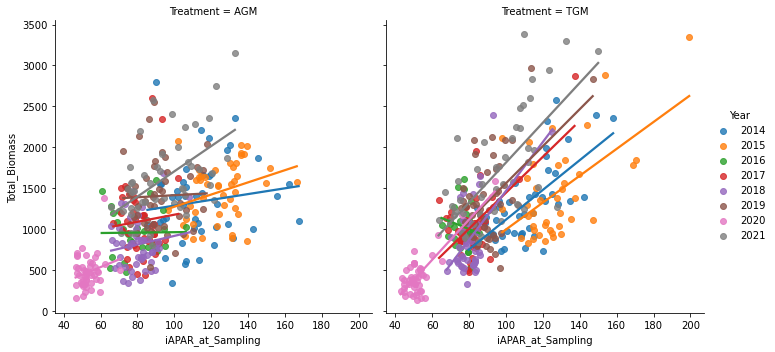

In [29]:
import seaborn as sns
sns.lmplot(x='iAPAR_at_Sampling', y='Total_Biomass', hue='Year', col='Treatment', ci=None, 
           data=df_grouped)

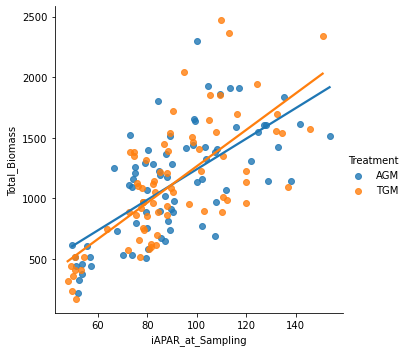

In [28]:
sns.lmplot(x='iAPAR_at_Sampling', y='Total_Biomass', hue='Treatment', ci=None, 
           data=df_grouped.groupby(['Year', 'Pasture', 'Treatment']).mean().reset_index())

In [ ]:
#output to CSV
df_grouped.to_csv('../data/training/iapar/cper_iapar_production.csv', index=False)

#output to CSV
APAR.to_csv('../data/training/cper_apar_plotscale_2014_2022.csv', index=False)